提取空间注意力和时间注意力的功能，并生成相应的热力图
第1部分 - 导入和类定义：

Processing videos:  10%|█         | 1/10 [00:08<01:12,  8.07s/it]

Processed bW3uJBsFRQ0.mp4: Prediction = 373, True Label = 373
Results saved in: attention_results/bW3uJBsFRQ0


Processing videos:  20%|██        | 2/10 [00:16<01:04,  8.07s/it]

Processed vHLLAEj3Cl8.mp4: Prediction = 217, True Label = 217
Results saved in: attention_results/vHLLAEj3Cl8


Processing videos:  30%|███       | 3/10 [00:24<00:58,  8.29s/it]

Processed nlHm20xZgmE.mp4: Prediction = 258, True Label = 258
Results saved in: attention_results/nlHm20xZgmE


Processing videos:  40%|████      | 4/10 [00:32<00:49,  8.26s/it]

Processed nNYBWW-mfo0.mp4: Prediction = 390, True Label = 390
Results saved in: attention_results/nNYBWW-mfo0


Processing videos:  50%|█████     | 5/10 [00:42<00:43,  8.66s/it]

Processed zeQDM7PrG08.mp4: Prediction = 88, True Label = 88
Results saved in: attention_results/zeQDM7PrG08


Processing videos:  50%|█████     | 5/10 [00:43<00:43,  8.77s/it]


KeyboardInterrupt: 

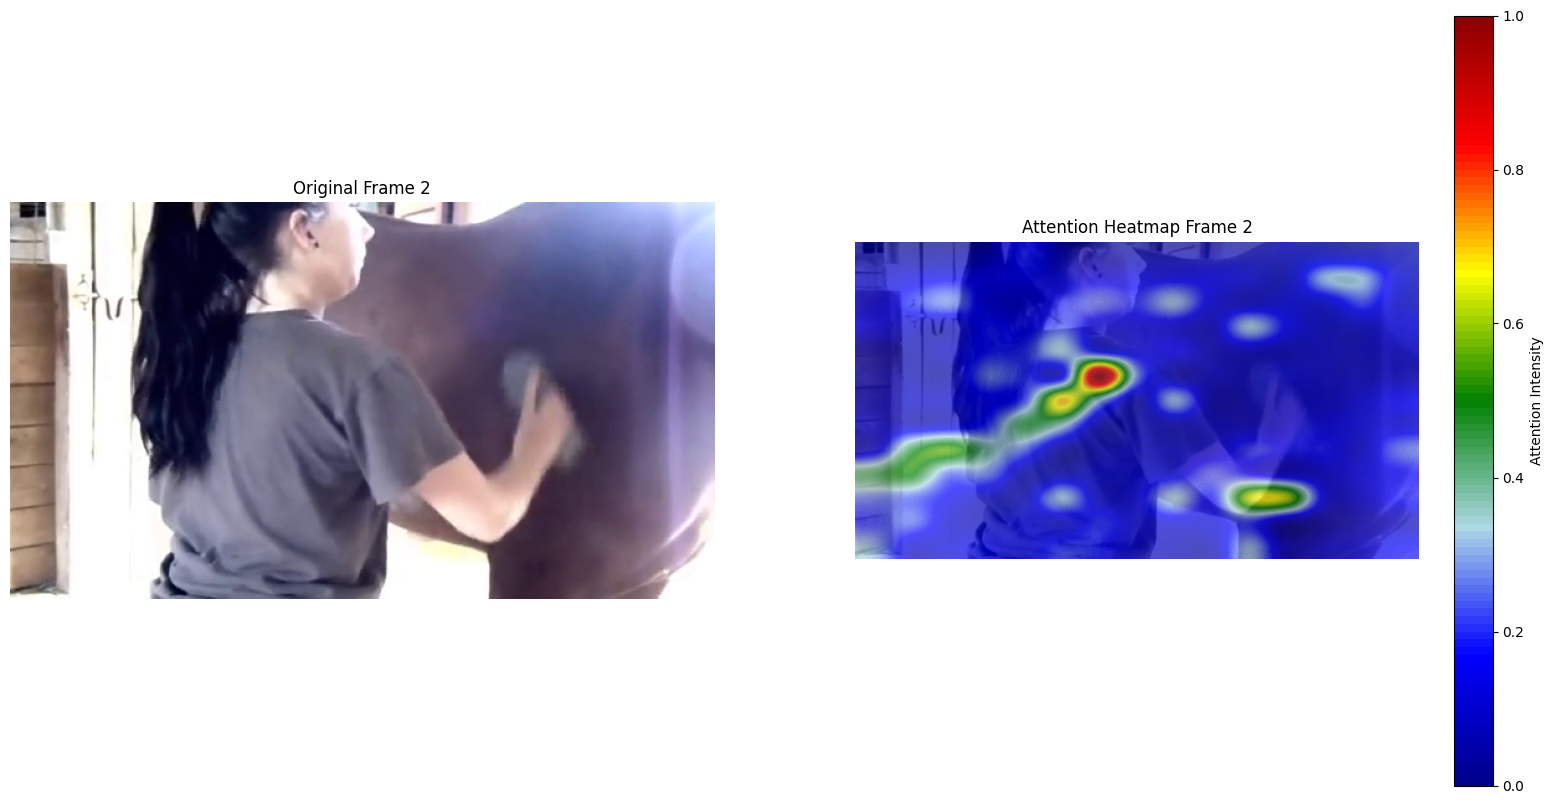

In [17]:
import os
import av
import torch
import numpy as np
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from matplotlib.colors import LinearSegmentedColormap

class AttentionExtractor:
    def __init__(self, model_name, device='cuda'):
        self.model = TimesformerForVideoClassification.from_pretrained(model_name)
        self.model.to(device)
        self.device = device
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)

    def extract_attention(self, video_path, num_frames=8):
        container = av.open(video_path)
        frames = [frame.to_image() for frame in container.decode(video=0)]
        sampled_frames = [frames[i] for i in np.linspace(0, len(frames) - 1, num_frames, dtype=int)]
        
        inputs = self.image_processor(sampled_frames, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)
        
        last_layer_attention = outputs.attentions[-1]
        cls_attention = last_layer_attention.mean(1)[:, 0, 1:]
        
        return cls_attention, sampled_frames, outputs.logits

    def visualize_attention(self, cls_attention, frames, save_path, prediction, true_label):
        num_frames = len(frames)
        attention_map = cls_attention.cpu().numpy().reshape(num_frames, -1)
        
        # Visualize overall attention
        plt.figure(figsize=(15, 5))
        plt.imshow(attention_map, aspect='auto', interpolation='nearest')
        plt.colorbar(label='Attention')
        plt.title(f"Overall Attention (Pred: {prediction}, True: {true_label})")
        plt.xlabel("Spatial Position")
        plt.ylabel("Frame")
        plt.savefig(f"{save_path}_overall_attention.png")
        plt.close()

        # Create a custom colormap
        colors = ["darkblue", "blue", "lightblue", "green", "yellow", "red", "darkred"]
        n_bins = 100
        cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

        # Visualize attention for each frame
        for i, (frame, att) in enumerate(zip(frames, attention_map)):
            # Original frame
            frame_array = np.array(frame)
            
            # Attention heatmap
            att_resized = att[1:].reshape(int(np.sqrt(len(att)-1)), -1)
            att_resized = Image.fromarray(att_resized).resize(frame.size, Image.BICUBIC)
            att_resized = np.array(att_resized)

            # Normalize attention values
            att_norm = (att_resized - att_resized.min()) / (att_resized.max() - att_resized.min())
            
            # Apply colormap to the attention
            att_color = (cmap(att_norm) * 255).astype(np.uint8)

            # Blend original frame with attention heatmap
            alpha = 0.7
            blended = (1 - alpha) * frame_array + alpha * att_color[:, :, :3]
            blended = np.clip(blended, 0, 255).astype(np.uint8)

            # Create a figure with two subplots side by side
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

            # Display original frame
            ax1.imshow(frame)
            ax1.axis('off')
            ax1.set_title(f"Original Frame {i+1}")

            # Display blended image
            ax2.imshow(blended)
            ax2.axis('off')
            ax2.set_title(f"Attention Heatmap Frame {i+1}")

            # Add colorbar
            fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax2, label='Attention Intensity')

            plt.tight_layout()
            plt.savefig(f"{save_path}_frame_{i+1}_attention.png", dpi=300, bbox_inches='tight')
            plt.close()

def load_labels(label_file):
    labels = {}
    with open(label_file, 'r') as f:
        for line in f:
            video_name, label = line.strip().split()
            labels[video_name] = int(label)
    return labels

def process_videos(config):
    extractor = AttentionExtractor(config['model_name'])
    labels = load_labels(config['label_file'])
    
    all_video_files = [f for f in os.listdir(config['video_directory']) if f.endswith('.mp4')]
    selected_videos = random.sample(all_video_files, min(config['num_videos'], len(all_video_files)))
    
    for video_file in tqdm(selected_videos, desc="Processing videos"):
        video_path = os.path.join(config['video_directory'], video_file)
        cls_attention, frames, logits = extractor.extract_attention(video_path)
        
        prediction = torch.argmax(logits, dim=1).item()
        true_label = labels.get(video_file, labels.get(video_file.split('.')[0], "Unknown"))
        
        save_path = os.path.join(config['output_directory'], video_file.split('.')[0])
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        extractor.visualize_attention(cls_attention, frames, save_path, prediction, true_label)
        
        print(f"Processed {video_file}: Prediction = {prediction}, True Label = {true_label}")
        print(f"Results saved in: {save_path}")

if __name__ == "__main__":
    config = {
        'model_name': 'facebook/timesformer-base-finetuned-k400',
        'video_directory': 'archive/videos_val',
        'output_directory': 'attention_results',
        'label_file': 'archive/kinetics400_val_list_videos.txt',
        'num_videos': 10
    }
    
    process_videos(config)

Processing videos:  10%|█         | 1/10 [00:10<01:30, 10.00s/it]

Processed awwbXD7N5W0.mp4: Prediction = 46, True Label = 46
Results saved in: attention_results/awwbXD7N5W0


Processing videos:  20%|██        | 2/10 [00:19<01:19,  9.96s/it]

Processed bKeiaJvBGws.mp4: Prediction = 329, True Label = 329
Results saved in: attention_results/bKeiaJvBGws


Processing videos:  30%|███       | 3/10 [00:30<01:13, 10.43s/it]

Processed 2-M5TagOHMw.mp4: Prediction = 53, True Label = 54
Results saved in: attention_results/2-M5TagOHMw


Processing videos:  40%|████      | 4/10 [00:41<01:02, 10.36s/it]

Processed plJH3_MfYzg.mp4: Prediction = 103, True Label = 103
Results saved in: attention_results/plJH3_MfYzg


Processing videos:  40%|████      | 4/10 [00:46<01:09, 11.61s/it]


KeyboardInterrupt: 

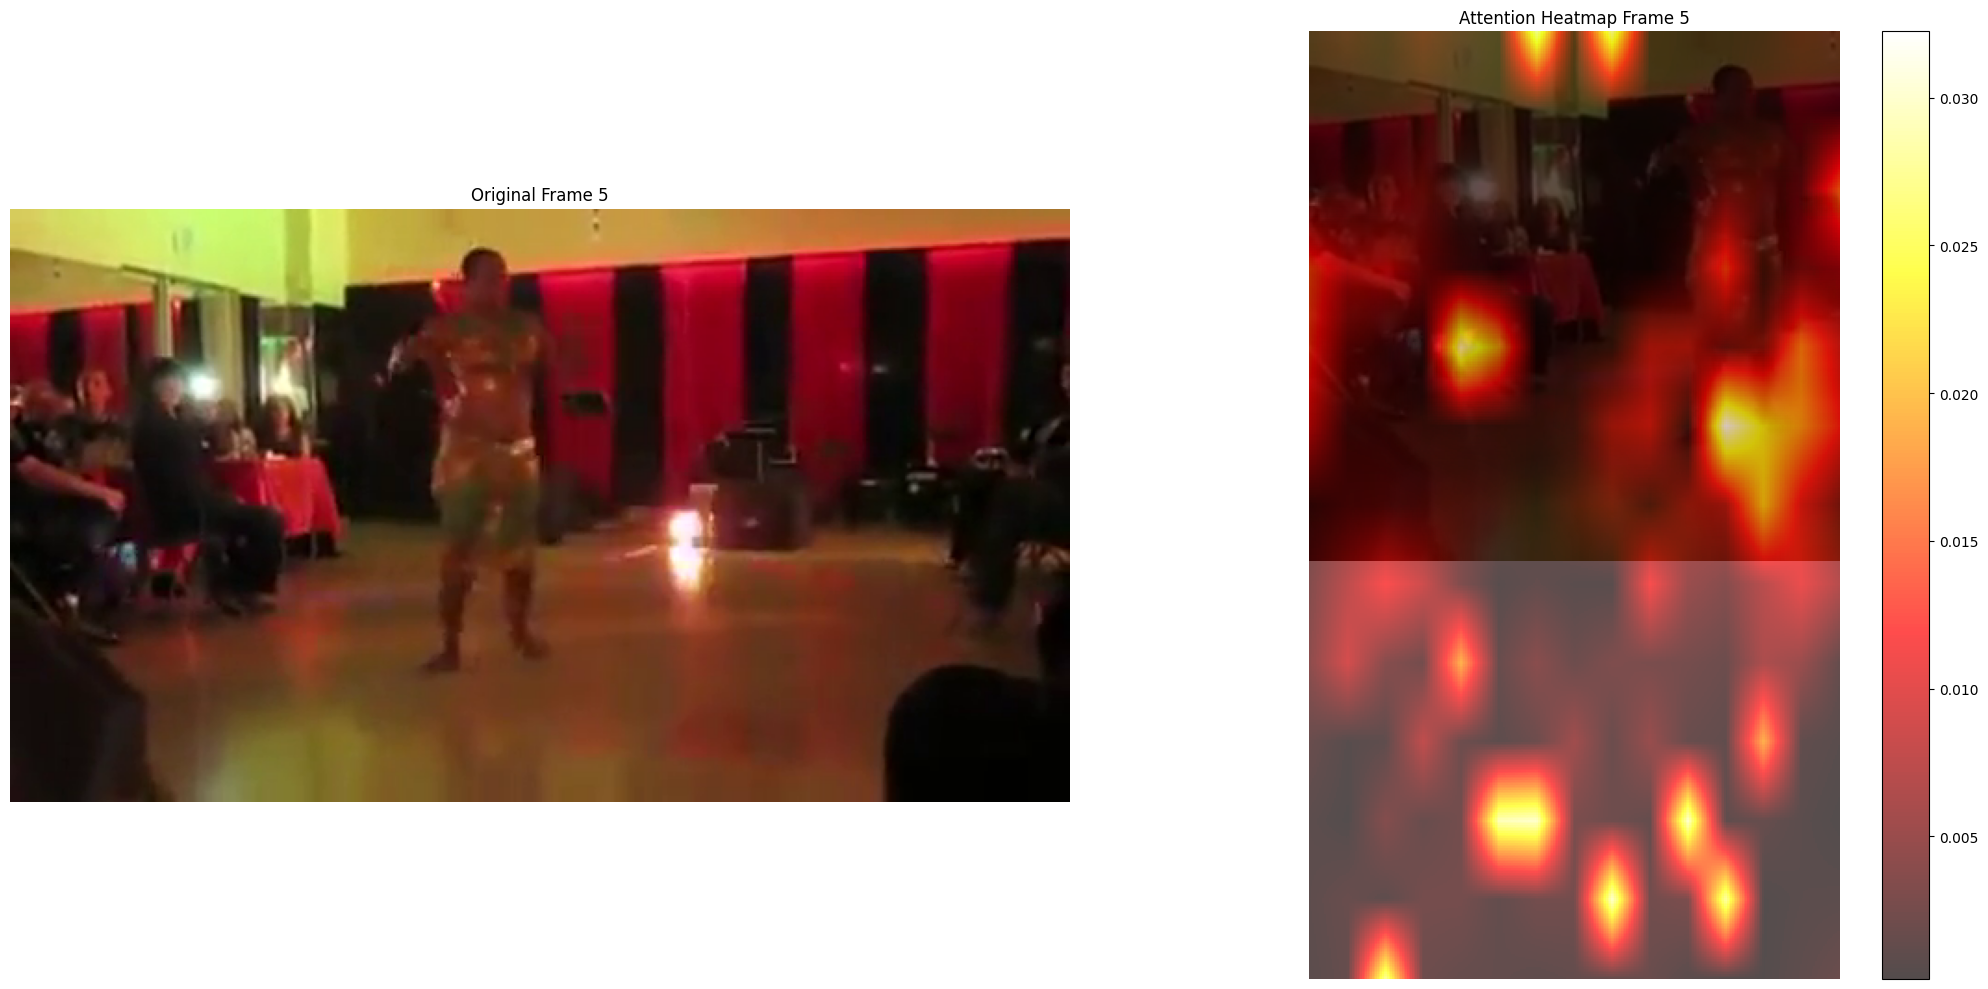

In [18]:
import os
import av
import torch
import numpy as np
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from scipy.ndimage import zoom

class AttentionExtractor:
    def __init__(self, model_name, device='cuda'):
        self.model = TimesformerForVideoClassification.from_pretrained(model_name)
        self.model.to(device)
        self.device = device
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)

    def extract_attention(self, video_path, num_frames=8):
        container = av.open(video_path)
        frames = [frame.to_image() for frame in container.decode(video=0)]
        sampled_frames = [frames[i] for i in np.linspace(0, len(frames) - 1, num_frames, dtype=int)]
        
        inputs = self.image_processor(sampled_frames, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)
        
        last_layer_attention = outputs.attentions[-1]
        cls_attention = last_layer_attention.mean(1)[:, 0, 1:]
        
        return cls_attention, sampled_frames, outputs.logits

    def visualize_attention(self, cls_attention, frames, save_path, prediction, true_label):
        num_frames = len(frames)
        attention_map = cls_attention.cpu().numpy().reshape(num_frames, -1)
        
        # Visualize overall attention
        plt.figure(figsize=(15, 5))
        plt.imshow(attention_map, aspect='auto', interpolation='nearest')
        plt.colorbar(label='Attention')
        plt.title(f"Overall Attention (Pred: {prediction}, True: {true_label})")
        plt.xlabel("Spatial Position")
        plt.ylabel("Frame")
        plt.savefig(f"{save_path}_overall_attention.png")
        plt.close()

        # Visualize attention for each frame
        for i, (frame, att) in enumerate(zip(frames, attention_map)):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            
            # Original frame
            ax1.imshow(frame)
            ax1.axis('off')
            ax1.set_title(f"Original Frame {i+1}")
            
            # Attention heatmap
            h, w = frame.size
            att_resized = att[1:].reshape(int(np.sqrt(len(att)-1)), -1)
            
            # Use scipy.ndimage.zoom for smoother interpolation
            zoom_h, zoom_w = h / att_resized.shape[0], w / att_resized.shape[1]
            att_resized = zoom(att_resized, (zoom_h, zoom_w), order=1)
            
            ax2.imshow(frame)
            im = ax2.imshow(att_resized, cmap='hot', alpha=0.7, interpolation='nearest', extent=(0, w, h, 0))
            ax2.axis('off')
            ax2.set_title(f"Attention Heatmap Frame {i+1}")
            
            plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
            plt.tight_layout()
            plt.savefig(f"{save_path}_frame_{i+1}_attention.png", dpi=300, bbox_inches='tight')
            plt.close()

def load_labels(label_file):
    labels = {}
    with open(label_file, 'r') as f:
        for line in f:
            video_name, label = line.strip().split()
            labels[video_name] = int(label)
    return labels

def process_videos(config):
    extractor = AttentionExtractor(config['model_name'])
    labels = load_labels(config['label_file'])
    
    all_video_files = [f for f in os.listdir(config['video_directory']) if f.endswith('.mp4')]
    selected_videos = random.sample(all_video_files, min(config['num_videos'], len(all_video_files)))
    
    for video_file in tqdm(selected_videos, desc="Processing videos"):
        video_path = os.path.join(config['video_directory'], video_file)
        cls_attention, frames, logits = extractor.extract_attention(video_path)
        
        prediction = torch.argmax(logits, dim=1).item()
        true_label = labels.get(video_file, labels.get(video_file.split('.')[0], "Unknown"))
        
        save_path = os.path.join(config['output_directory'], video_file.split('.')[0])
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        extractor.visualize_attention(cls_attention, frames, save_path, prediction, true_label)
        
        print(f"Processed {video_file}: Prediction = {prediction}, True Label = {true_label}")
        print(f"Results saved in: {save_path}")

if __name__ == "__main__":
    config = {
        'model_name': 'facebook/timesformer-base-finetuned-k400',
        'video_directory': 'archive/videos_val',
        'output_directory': 'attention_results',
        'label_file': 'archive/kinetics400_val_list_videos.txt',
        'num_videos': 10
    }
    
    process_videos(config)

第2部分 - 辅助函数：

第3部分 - 主程序：

这个版本已经可以实现从timesformer 提取 self attention

TimesformerForVideoClassification(
  (timesformer): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense

Processing videos:  10%|█         | 1/10 [00:09<01:27,  9.71s/it]

Spatial attention shape: torch.Size([8, 197, 197])
Temporal attention shape: torch.Size([8, 8])
Processed bFiXo1rNCHk.mp4: Prediction = 70, True Label = 73
Results saved in: attention_results/bFiXo1rNCHk


Processing videos:  10%|█         | 1/10 [00:11<01:41, 11.23s/it]


KeyboardInterrupt: 

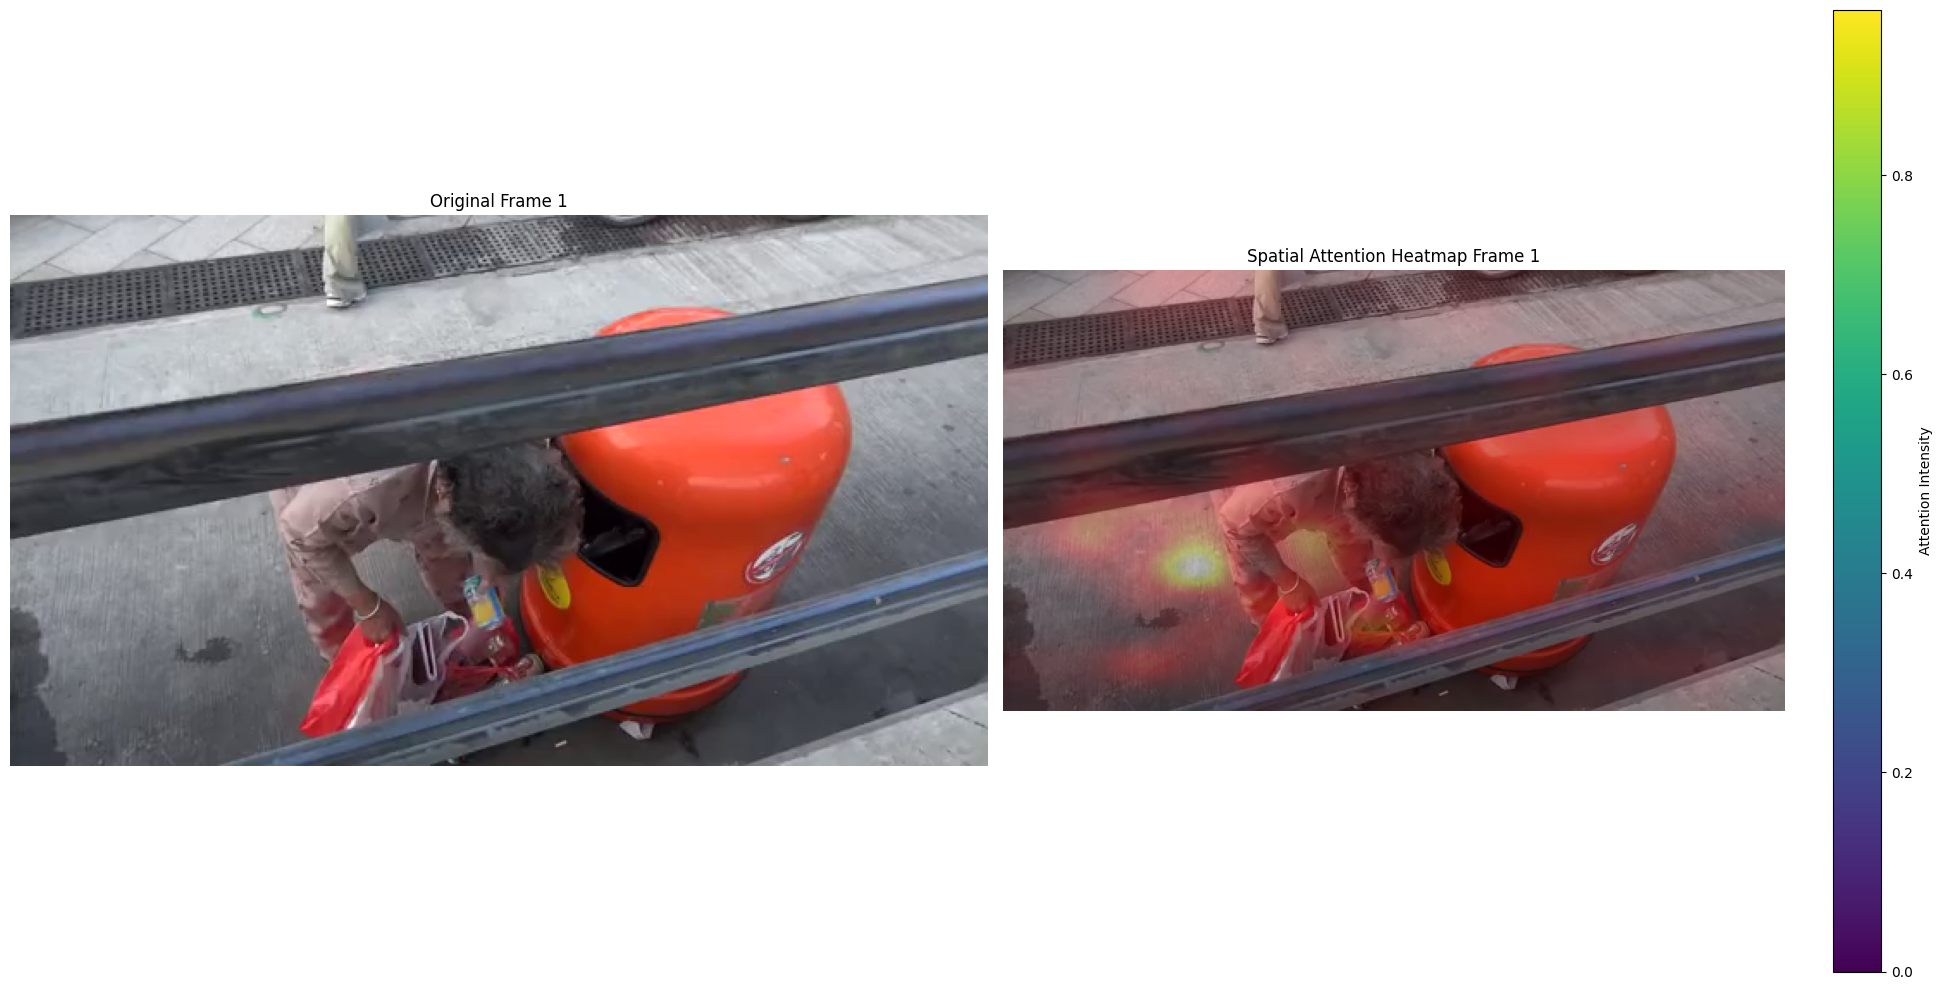

In [31]:
import os
import av
import torch
import numpy as np
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

class AttentionExtractor:
    def __init__(self, model_name, device='cuda'):
        self.model = TimesformerForVideoClassification.from_pretrained(model_name)
        self.model.to(device)
        self.device = device
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)

    def print_model_structure(self):
        print(self.model)

    def extract_attention(self, video_path, num_frames=8):
        container = av.open(video_path)
        frames = [frame.to_image() for frame in container.decode(video=0)]
        sampled_frames = [frames[i] for i in np.linspace(0, len(frames) - 1, num_frames, dtype=int)]
        
        inputs = self.image_processor(sampled_frames, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)
        
        # Extract attention from the last layer
        last_layer_attention = outputs.attentions[-1]
        
        # Extract spatial attention (average over heads)
        spatial_attention = last_layer_attention.mean(1)
        
        # Extract temporal attention (use the attention of the CLS token to all frames)
        temporal_attention = spatial_attention[:, 0, 1:num_frames+1]
        
        return spatial_attention, temporal_attention, sampled_frames, outputs.logits

    def visualize_attention(self, spatial_attention, temporal_attention, frames, save_path, prediction, true_label):
        num_frames = len(frames)
        
        # Visualize spatial attention
        for i, frame in enumerate(frames):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
            
            # Original frame
            ax1.imshow(frame)
            ax1.axis('off')
            ax1.set_title(f"Original Frame {i+1}")
            
            # Spatial attention heatmap
            att_map = spatial_attention[0, i+1, 1:].reshape(int(np.sqrt(spatial_attention.shape[2]-1)), -1).cpu().numpy()
            att_resized = Image.fromarray(att_map).resize(frame.size, Image.BICUBIC)
            att_resized = np.array(att_resized)
            
            # Normalize attention values
            att_norm = (att_resized - att_resized.min()) / (att_resized.max() - att_resized.min())
            
            # Convert frame to numpy array if it's not already
            frame_array = np.array(frame)
            
            # Create a heatmap overlay
            heatmap = plt.cm.hot(att_norm)
            heatmap = heatmap[..., :3]  # Remove alpha channel
            
            # Blend original frame with heatmap
            blend = 0.7 * frame_array / 255 + 0.3 * heatmap
            blend = np.clip(blend, 0, 1)
            
            # Display blended image
            im = ax2.imshow(blend)
            ax2.axis('off')
            ax2.set_title(f"Spatial Attention Heatmap Frame {i+1}")
            
            plt.colorbar(im, ax=ax2, label='Attention Intensity')
            plt.tight_layout()
            plt.savefig(f"{save_path}_frame_{i+1}_spatial_attention.png", dpi=300, bbox_inches='tight')
            plt.close()
        
        # Visualize temporal attention
        temporal_att = temporal_attention[0].cpu().numpy()
        plt.figure(figsize=(15, 5))
        plt.imshow(temporal_att.reshape(1, -1), aspect='auto', interpolation='nearest')
        plt.colorbar(label='Attention')
        plt.title(f"Temporal Attention (Pred: {prediction}, True: {true_label})")
        plt.xlabel("Frame")
        plt.ylabel("CLS Token Attention")
        plt.savefig(f"{save_path}_temporal_attention.png", dpi=300, bbox_inches='tight')
        plt.close()

        # Print attention shapes for debugging
        print(f"Spatial attention shape: {spatial_attention.shape}")
        print(f"Temporal attention shape: {temporal_attention.shape}")

def load_labels(label_file):
    labels = {}
    with open(label_file, 'r') as f:
        for line in f:
            video_name, label = line.strip().split()
            labels[video_name] = int(label)
    return labels

def process_videos(config):
    extractor = AttentionExtractor(config['model_name'])
    
    if config['print_model']:
        extractor.print_model_structure()
    
    labels = load_labels(config['label_file'])
    
    all_video_files = [f for f in os.listdir(config['video_directory']) if f.endswith('.mp4')]
    selected_videos = random.sample(all_video_files, min(config['num_videos'], len(all_video_files)))
    
    for video_file in tqdm(selected_videos, desc="Processing videos"):
        video_path = os.path.join(config['video_directory'], video_file)
        spatial_attention, temporal_attention, frames, logits = extractor.extract_attention(video_path)
        
        prediction = torch.argmax(logits, dim=1).item()
        true_label = labels.get(video_file, labels.get(video_file.split('.')[0], "Unknown"))
        
        save_path = os.path.join(config['output_directory'], video_file.split('.')[0])
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        extractor.visualize_attention(spatial_attention, temporal_attention, frames, save_path, prediction, true_label)
        
        print(f"Processed {video_file}: Prediction = {prediction}, True Label = {true_label}")
        print(f"Results saved in: {save_path}")

if __name__ == "__main__":
    config = {
        'model_name': 'facebook/timesformer-base-finetuned-k400',
        'video_directory': 'archive/videos_val',
        'output_directory': 'attention_results',
        'label_file': 'archive/kinetics400_val_list_videos.txt',
        'num_videos': 10,
        'print_model': True  # 设置为 True 以打印模型结构
    }
    
    process_videos(config)

目标是为了更好的平滑显示heatmap